In [1]:
import os
import numpy as np
import csv
import keras
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import yfinance as yf
import math
import time
import sklearn.metrics
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import Sequential
from keras.models import Sequential

In [3]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [ ]:
cpy_tweet = pd.read_csv('Company_Tweet.csv')

In [ ]:
tweet = pd.read_csv('Tweet.csv')

In [ ]:
tweets = pd.merge(tweet,cpy_tweet,on='tweet_id',how='inner')
tweets.head()

In [ ]:
tweets['post_date'] = pd.to_datetime(tweets['post_date'], unit='s')
tweets['date'] = pd.to_datetime(tweets['post_date'].apply(lambda date: date.date()))
tweets['date'].head()

In [ ]:
all_tweets = tweets.drop(['tweet_id', 'writer', 'post_date'],axis=1)

In [ ]:
all_tweets.isna().sum()

In [ ]:
tweets.ticker_symbol.value_counts()

In [ ]:
sentiment_analyzer = SentimentIntensityAnalyzer()

In [ ]:
def initialize_dataframe(df):
    sent_df = df.copy()
    sent_df["sentiment_score"] = ''
    sent_df["Negative"] = ''
    sent_df["Neutral"] = ''
    sent_df["Positive"] = ''
    sent_df.head()
    return sent_df

In [ ]:
def sentiment_score(sent_df, sentiment_analyzer):
    for indx, row in sent_df.T.iteritems():
        sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'body'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    return sent_df

In [ ]:
def process_data_frame(sent_df):
    sent_df2 = sent_df.copy() # default:true
    sent_df2['date'] = pd.to_datetime(sent_df2['date'])
    sent_df2['sentiment_score'] = pd.to_numeric(sent_df2['sentiment_score'], errors='coerce')
    sent_df2 = sent_df2[['date', 'body', 'sentiment_score']]
    return sent_df2

In [ ]:
def avg_sentiment_scores(sent_df2):
    twitter_df = sent_df2.groupby([sent_df2['date']]).mean()
    return twitter_df

In [ ]:
# Combine sentiment scores with stock price data
def combine_data(sp500_data,twitter_df,column):
    sp500_data[column] = 0
    for date in sp500_data.index:
        date_str = date.strftime('%Y-%m-%d')
        for i in range(len(twitter_df)):
            if twitter_df.index[i].strftime('%Y-%m-%d')  == date_str:
                sp500_data.at[date, column] = twitter_df['sentiment_score'][i]
    return sp500_data

In [ ]:
sp500_data = pd.read_csv('S&P500_new.csv')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

In [ ]:
inflation_rate = pd.read_csv('InflationRates_fred.csv')
inflation_rate['Date'] = pd.to_datetime(inflation_rate['Date'])

In [ ]:
sp500_data = pd.merge(sp500_data,inflation_rate,on='Date',how='left')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

In [ ]:
x = inflation_rate['Rate'].median()
sp500_data['Rate'].fillna(x, inplace=True)

In [ ]:
interest_rate = pd.read_csv('EFFR.csv')
interest_rate['Date'] = pd.to_datetime(interest_rate['Date'])

In [ ]:
interest_rate

In [ ]:
sp500_data = pd.merge(sp500_data,interest_rate,on='Date',how='left')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

In [ ]:
sp500_data.shape

In [ ]:
#sp500_data['UMCSENT'] = sp500_data['UMCSENT'].fillna(method='ffill')

In [ ]:
s = interest_rate['EFFR'].median()
sp500_data['EFFR'].fillna(s, inplace=True)

In [ ]:
stock_name = 'AMZN'
df = all_tweets[all_tweets['ticker_symbol'] == stock_name]
print(df.shape)
df.head()

In [ ]:
sent_df = initialize_dataframe(df)
sent_df = sentiment_score(sent_df, sentiment_analyzer)
sent_df2 = process_data_frame(sent_df)
twitter_df = avg_sentiment_scores(sent_df2)

In [ ]:
sp500_data = combine_data(sp500_data,twitter_df,'ss_amzn')

In [ ]:
stock_name = 'AAPL'
df = all_tweets[all_tweets['ticker_symbol'] == stock_name]
print(df.shape)
df.head()

In [ ]:
sent_df = initialize_dataframe(df)
sent_df = sentiment_score(sent_df, sentiment_analyzer)
sent_df2 = process_data_frame(sent_df)
twitter_df = avg_sentiment_scores(sent_df2)

In [ ]:
sp500_data = combine_data(sp500_data,twitter_df,'ss_aapl')

In [ ]:
stock_name = 'MSFT'
df = all_tweets[all_tweets['ticker_symbol'] == stock_name]
print(df.shape)
df.head()

In [ ]:
sent_df = initialize_dataframe(df)
sent_df = sentiment_score(sent_df, sentiment_analyzer)
sent_df2 = process_data_frame(sent_df)
twitter_df = avg_sentiment_scores(sent_df2)

In [ ]:
sp500_data = combine_data(sp500_data,twitter_df,'ss_msft')

In [ ]:
stock_name = 'GOOGL'
df = all_tweets[all_tweets['ticker_symbol'] == stock_name]
print(df.shape)
df.head()

In [ ]:
sent_df = initialize_dataframe(df)
sent_df = sentiment_score(sent_df, sentiment_analyzer)
sent_df2 = process_data_frame(sent_df)
twitter_df = avg_sentiment_scores(sent_df2)

In [ ]:
sp500_data = combine_data(sp500_data,twitter_df,'ss_googl')

In [ ]:
corr_matrix = sp500_data.corr()
corr_matrix['Close'].sort_values(ascending = False)

In [ ]:
sp500_data.to_csv('sp500_data.csv')

In [ ]:
# Select the input features and target variable
features = ['Open','Close', 'ss_amzn', 'ss_aapl', 'ss_msft', 'ss_googl', 'Rate', 'EFFR']

In [ ]:
import seaborn as sns
heatmap = sns.heatmap(sp500_data[features].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [4]:
sp500_data = pd.read_csv('sp500_data.csv')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)
# Select the input features and target variable
#features = ['Open','Close', 'ss_amzn' , 'ss_aapl', 'ss_msft', 'ss_googl', 'Rate', 'EFFR' ]
features = ['Open','Close', 'ss_amzn' , 'ss_aapl', 'ss_msft', 'ss_googl','Rate', 'EFFR' ]

In [ ]:
sp500_data

In [5]:
dataset = sp500_data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.9)
training_data_len

1132

In [6]:
#Scale the data
data = sp500_data
scaler = MinMaxScaler(feature_range = (0,1))
data[features] = scaler.fit_transform(data[features] )


In [7]:
#Create the training dataset
train_data = data.iloc[:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i][features].values)
    y_train.append(train_data[i:i+1]['Close'].values)
    if i<=61:
        print(x_train)
        print(y_train)


[array([[0.15949576, 0.16238818, 0.39508511, 0.2420562 , 0.69243069,
        0.39908833, 0.53      , 0.46025105],
       [0.15634123, 0.13572511, 0.51516898, 0.33666389, 0.55575535,
        0.96148548, 0.46      , 0.0292887 ],
       [0.13350262, 0.12298894, 0.42063351, 0.3662851 , 0.54775272,
        1.        , 0.38      , 0.0251046 ],
       [0.12176148, 0.1394957 , 0.24616847, 0.35658958, 0.59300359,
        0.84537092, 0.39      , 0.0292887 ],
       [0.13948634, 0.16518061, 0.38613833, 0.38855041, 0.71565298,
        0.67535736, 0.44      , 0.46025105],
       [0.162714  , 0.15289813, 0.41288599, 0.34129285, 0.55108639,
        0.5906138 , 0.44      , 0.0334728 ],
       [0.15046363, 0.14116833, 0.51127246, 0.35723595, 0.72494744,
        0.55805795, 0.39      , 0.0292887 ],
       [0.1401724 , 0.1374616 , 0.49764671, 0.36572394, 0.67943294,
        0.60776981, 0.36      , 0.0251046 ],
       [0.13085025, 0.12912672, 0.42135848, 0.27027179, 0.55133719,
        0.32288248, 0.39   

In [8]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
np.random.seed(123)
#tensorflow.random.set_seed(123)

In [10]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],len(features))))
model.add(Dropout(0.1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [11]:
#Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss='mean_squared_error')

In [12]:
es = tensorflow.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 15, restore_best_weights = True)

In [13]:
#Train the model
model.fit(x_train,y_train,batch_size = 16, validation_split = 0.2, epochs = 50, callbacks = [es])

Epoch 1/50
54/54 [==============================] - 5s 48ms/step - loss: 0.0668 - val_loss: 0.0057
Epoch 2/50
54/54 [==============================] - 2s 38ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 3/50
54/54 [==============================] - 2s 38ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 4/50
54/54 [==============================] - 2s 38ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 5/50
54/54 [==============================] - 2s 36ms/step - loss: 8.7118e-04 - val_loss: 0.0045
Epoch 6/50
54/54 [==============================] - 2s 36ms/step - loss: 9.0807e-04 - val_loss: 0.0027
Epoch 7/50
54/54 [==============================] - 2s 36ms/step - loss: 8.5931e-04 - val_loss: 0.0016
Epoch 8/50
54/54 [==============================] - 2s 37ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 9/50
54/54 [==============================] - 2s 37ms/step - loss: 7.7594e-04 - val_loss: 0.0023
Epoch 10/50
54/54 [==============================] - 2s 41ms/step - loss: 6.7718e-04 - val_lo

<AxesSubplot:>

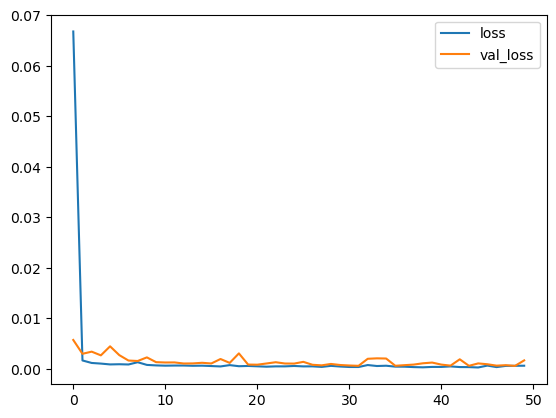

In [14]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [15]:
#Create the testing data set
#Create a new array containing scaled values from last 60 index
test_data = data.iloc[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len-60:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i][features].values)

In [16]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [17]:
#Get the models predicted price values
predictions = model.predict(x_test)

4/4 [==============================] - 1s 16ms/step


In [ ]:
predictions.shape

In [18]:
predicted1 = np.repeat(predictions, len(features), axis = -1)
predicted_descaled= scaler.inverse_transform(predicted1)[:, 0]

In [19]:
symbol = "^GSPC"
df1 = yf.download(symbol, start='2015-01-01', end='2019-12-31',interval = "1d")
df1.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000


In [20]:
y_test = df1.iloc[training_data_len:, :]

In [21]:
y_test = y_test['Close']

In [ ]:
predicted_descaled.shape

In [22]:
mse = sklearn.metrics.mean_squared_error(y_test, predicted_descaled)
rmse = math.sqrt(mse)
rmse

41.3263246402532

In [23]:
def print_mean_absolute_percentage_error(y_test, predicted_descaled): 
    mape = np.mean(np.abs((y_test - predicted_descaled) / y_test)) * 100
    print('mape = ', mape)

print_mean_absolute_percentage_error(y_test, predicted_descaled)

mape =  1.0735823640241426


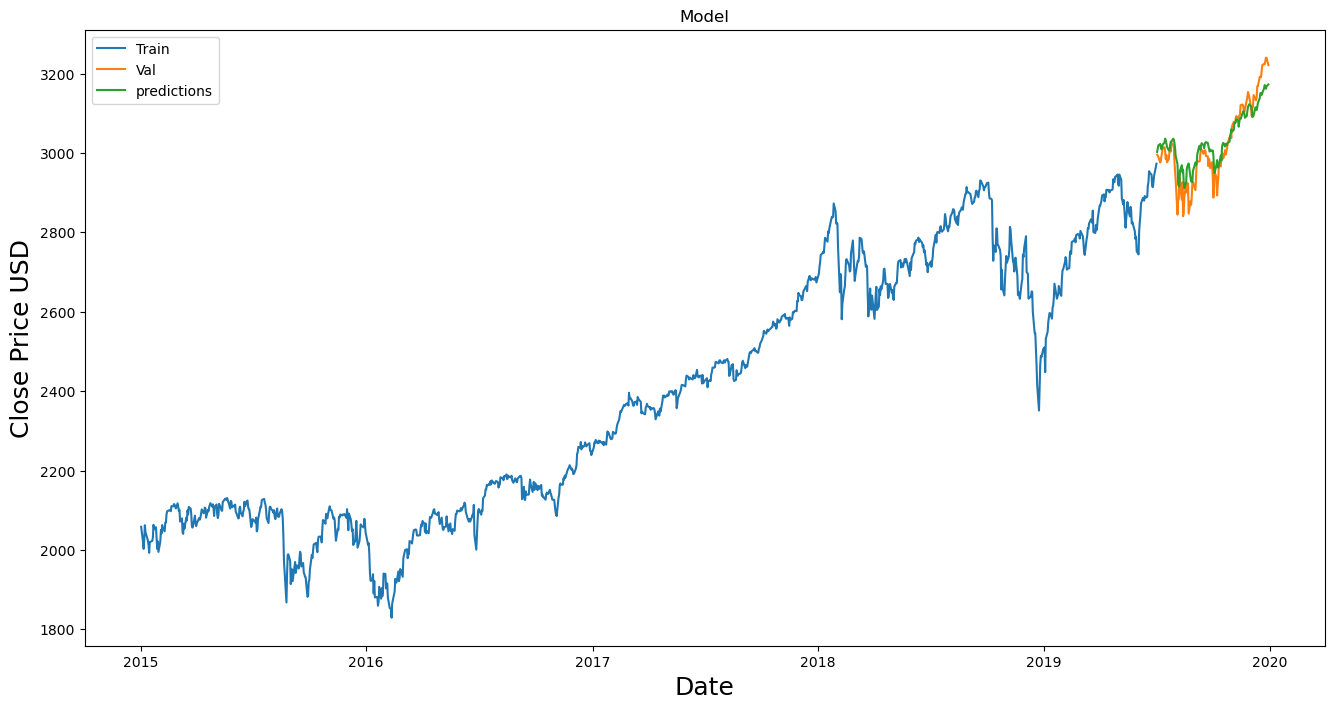

In [24]:
#Plot the data
data_set = df1.filter(['Close'])
train = data_set[:training_data_len]
valid = data_set[training_data_len:]
valid['Predictions'] = predicted_descaled
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','predictions'])
plt.show()

In [ ]:
#Grid Search
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
# # Function to create model, required for KerasClassifier
def create_model(dropout_rate = 0.0):
    # create model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],len(features))))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())
    return model

In [ ]:
# fix random seed for reproducibility
seed = 128
np.random.seed(seed)

model = KerasRegressor(build_fn=create_model, verbose=1)
# define the grid search parameters
batch_size = [16, 32]
epochs = [50]
dropout_rate = [0.1]
param_grid = dict(dropout_rate = dropout_rate,epochs = epochs, batch_size = batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))